In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix,classification_report,recall_score,confusion_matrix,mean_squared_error
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score,ShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
import re
from pandas_profiling import ProfileReport
pd.set_option("display.precision", 6)
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('Jan_2019_ontime.csv')
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [3]:
# instead of doing multi classification we will concatenate the arrival and departure delay in one column 
df['DELAYED'] = (df['ARR_DEL15'].astype(bool) | df['DEP_DEL15'].astype(bool)).astype(int)

In [4]:
# dropping unuseful column to decrease dimensionality
df.drop(['OP_CARRIER_AIRLINE_ID','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','Unnamed: 21','OP_CARRIER','ARR_DEL15','DEP_DEL15','CANCELLED', 'DIVERTED'], axis=1, inplace=True)

The following step must be done after choosing the features (feature engineering) 

In [5]:
# getting the object columns
strings_columns =  list(df.dtypes[df.dtypes == 'object'].index)
print(f"The number of string columns is: {len(strings_columns)}")
    
# getting int or float columns
numeric_columns = list(df.drop(strings_columns,axis=1))
print(f"The number of numeric columns is: {len(numeric_columns)}")


The number of string columns is: 4
The number of numeric columns is: 6


In [6]:
# to get percentage of null values on the whole data
(df.isna().sum() / df.shape[0]) * 100 

DAY_OF_MONTH         0.000000
DAY_OF_WEEK          0.000000
OP_UNIQUE_CARRIER    0.000000
ORIGIN               0.000000
DEST                 0.000000
DEP_TIME             2.800072
DEP_TIME_BLK         0.000000
ARR_TIME             2.921479
DISTANCE             0.000000
DELAYED              0.000000
dtype: float64

## The best solution for null values is to drop them as they represent approximatly 3% of data

In [7]:
df.dropna(inplace=True)
df.isna().any()

DAY_OF_MONTH         False
DAY_OF_WEEK          False
OP_UNIQUE_CARRIER    False
ORIGIN               False
DEST                 False
DEP_TIME             False
DEP_TIME_BLK         False
ARR_TIME             False
DISTANCE             False
DELAYED              False
dtype: bool

In [8]:
df.shape

(566924, 10)

In [9]:
df.duplicated().sum()

1

there is only one duplicated row  

In [10]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

the following step is to see the skewness of features 

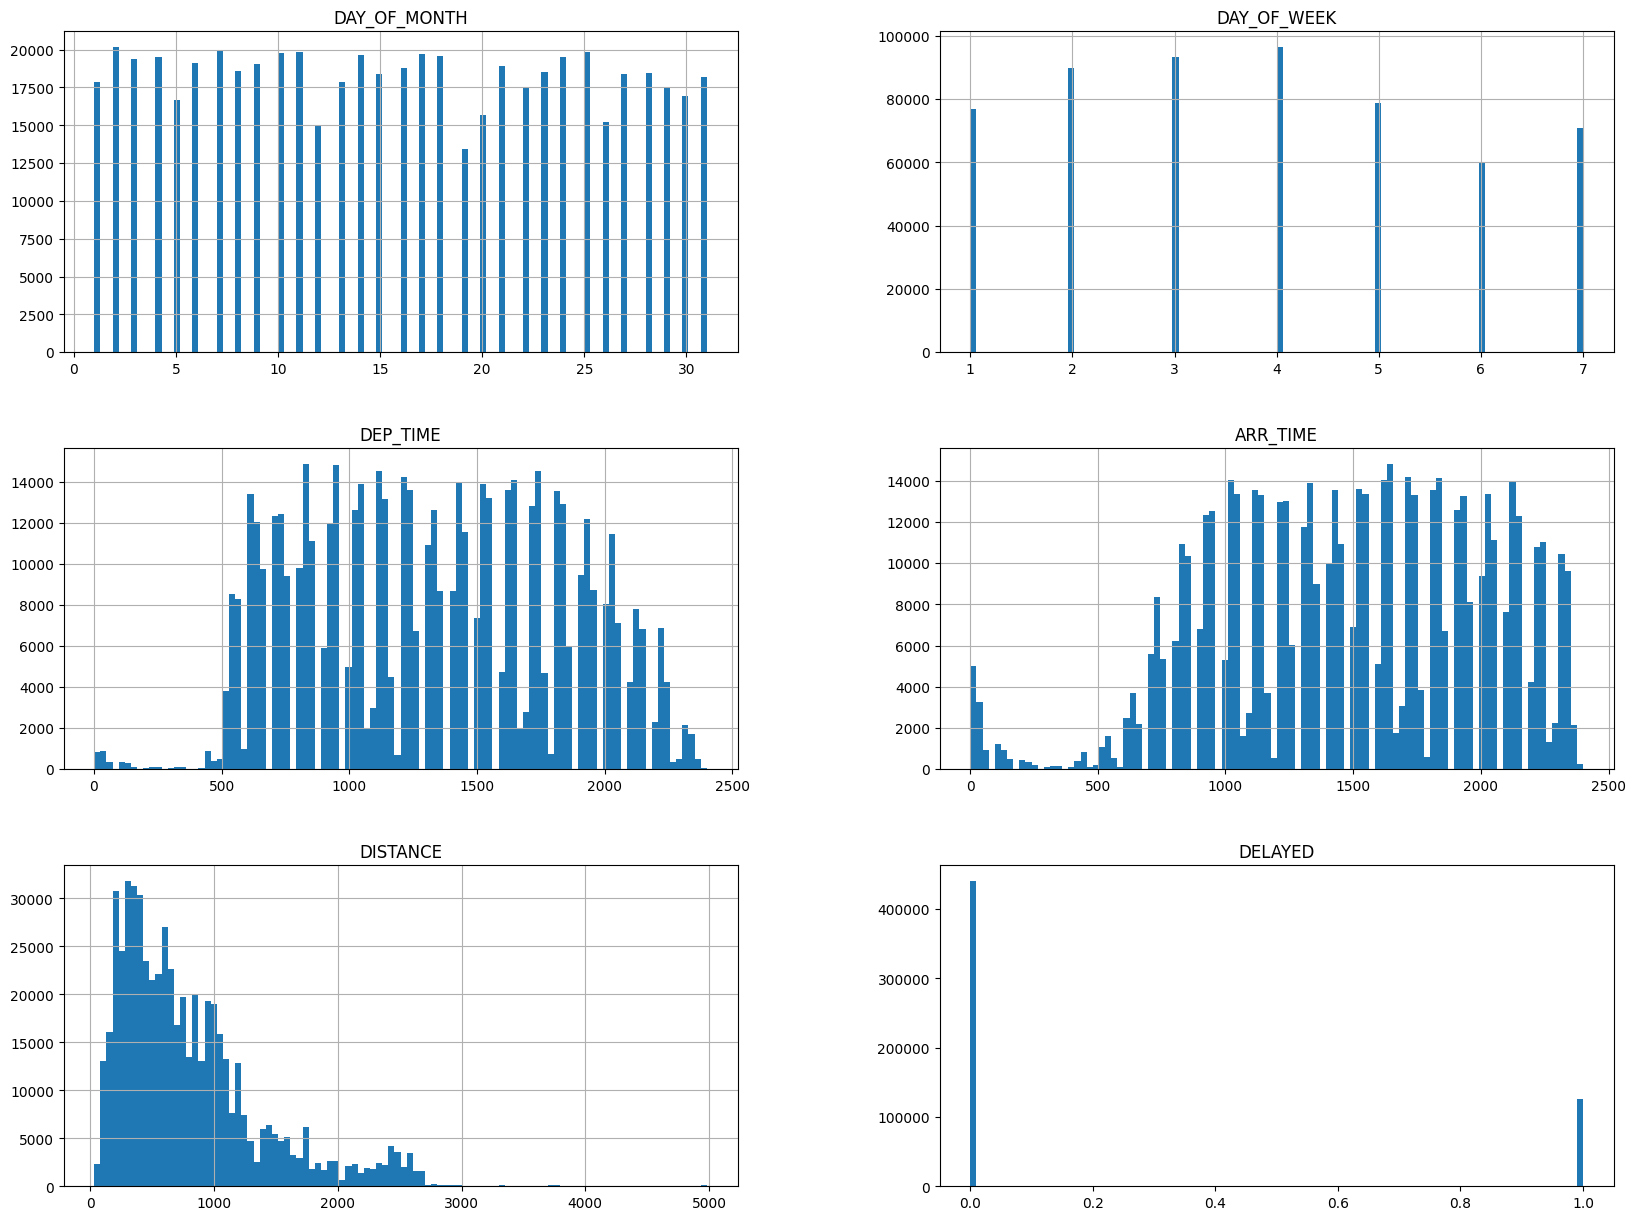

In [11]:
df.hist(bins=100,figsize=(20,15))
plt.grid()
plt.show()

## function to check outliers with box plot

In [12]:
def check_outliers(df):
    for col in numeric_columns:
        fig,ax= plt.subplots(figsize=(10,5))
        plt.grid()
        sns.boxplot(x = df[col])
        plt.show()


## Function to replace outliers with mean

In [13]:
def replace_outliers(df):
    for column in numeric_columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3-q1
        upper_lim = q3 + 1.5 * iqr
        lower_lim = q1 - 1.5 * iqr
        column_mean = df[column].mean()
        outliers_down = (df[column] < lower_lim)
        outliers_up = (df[column] > upper_lim)
        df[column] = np.where((df[column] > upper_lim) | (df[column] < lower_lim) , column_mean, df[column])
        df[column] = pd.DataFrame(df[column],columns=[column])
    return (df)
#replace_outliers(df)

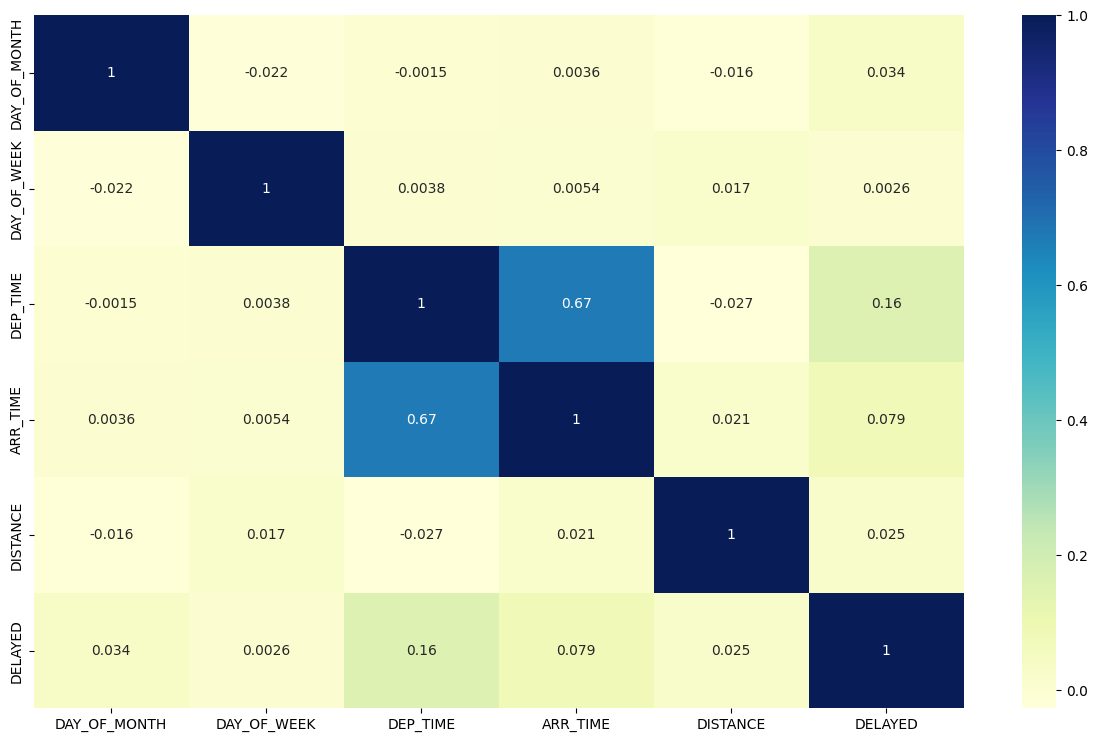

In [14]:
fig,ax = plt.subplots(figsize=(15,9))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu")
plt.show()


In [15]:
def encode_categories(features):
    lb_make = LabelEncoder()
    for i in range(len(features)):
        df[features[i]] = lb_make.fit_transform(df[features[i]])

## after preparing data, we have to make the final check before entering modeling phase

In [16]:
df.isna().sum()

DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
ORIGIN               0
DEST                 0
DEP_TIME             0
DEP_TIME_BLK         0
ARR_TIME             0
DISTANCE             0
DELAYED              0
dtype: int64

In [17]:
df.duplicated().sum()

0

In [ ]:
check_outliers(df)

The data is clean as there is no duplication, null values, and there is an outlier which is distance column but we can not handle it as the person may have a flight between 2 far countries, and it happens therefore the distance will be an outlier

## As there is a correlation between the folloing encoded column and label so, we will encode them and drag them to the model

In [19]:
encode_categories(['OP_UNIQUE_CARRIER' , 'ORIGIN' , 'DEST' , 'DEP_TIME_BLK'])

<IPython.core.display.Javascript object>

In [20]:
df.head(22)

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_TIME_BLK,ARR_TIME,DISTANCE,DELAYED
0,1,2,0,128,19,601.0,1,722.0,300.0,0
1,1,2,0,225,80,1359.0,9,1633.0,596.0,0
2,1,2,0,95,80,1215.0,7,1329.0,229.0,0
3,1,2,0,325,19,1521.0,10,1625.0,223.0,0
4,1,2,0,19,120,1847.0,14,1940.0,579.0,0
5,1,2,0,85,225,853.0,4,953.0,574.0,0
6,1,2,0,168,19,1553.0,10,1832.0,341.0,0
7,1,2,0,189,80,1551.0,10,1824.0,585.0,0
8,1,2,0,169,189,1037.0,5,1239.0,833.0,0
9,1,2,0,19,38,1245.0,7,1318.0,533.0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566923 entries, 0 to 583984
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DAY_OF_MONTH       566923 non-null  int64  
 1   DAY_OF_WEEK        566923 non-null  int64  
 2   OP_UNIQUE_CARRIER  566923 non-null  int32  
 3   ORIGIN             566923 non-null  int32  
 4   DEST               566923 non-null  int32  
 5   DEP_TIME           566923 non-null  float64
 6   DEP_TIME_BLK       566923 non-null  int32  
 7   ARR_TIME           566923 non-null  float64
 8   DISTANCE           566923 non-null  float64
 9   DELAYED            566923 non-null  int32  
dtypes: float64(3), int32(5), int64(2)
memory usage: 36.8 MB


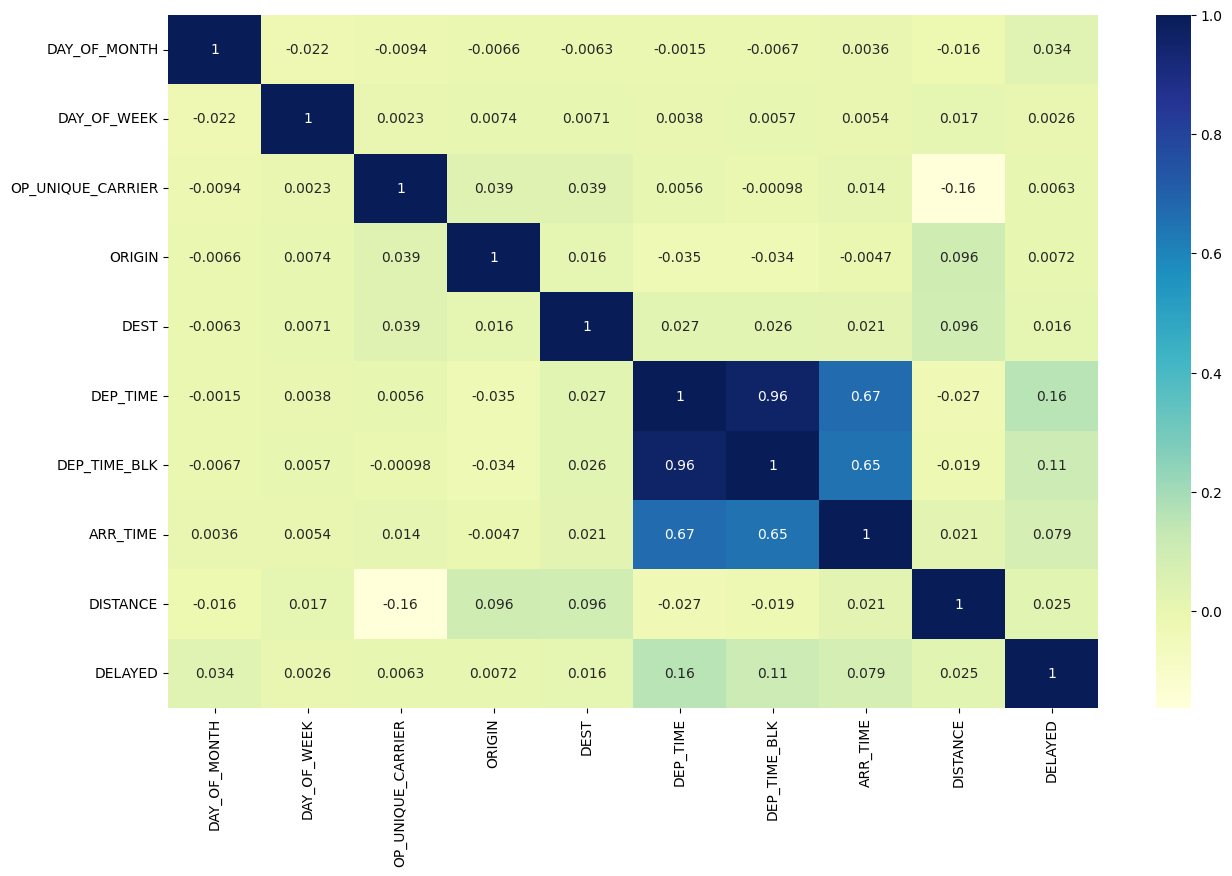

In [22]:
fig,ax = plt.subplots(figsize=(15,9))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu")
plt.show()

## Modeling

In [23]:
X = df.drop('DELAYED',axis=1)
y = df['DELAYED']

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

In [25]:
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5)))


In [26]:
for name, model in models:
    
    print(name)
    
    # Make predictions.
    
    trained_model = model.fit(x_train, y_train)
        
    predictions = trained_model.predict(x_test) 
    
    print(f"train score: {accuracy_score(y_train, trained_model.predict(x_train))}\n")
    
    print(f"test score: {accuracy_score(predictions,y_test)}\n\n")
    

LogisticRegression


NameError: name 'x_train' is not defined

## As the Random Forest has the best accuracy so, we will do the hyperparameter tuning on it

In [ ]:
# old accuracy
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
trained_model = rf.fit(x_train, y_train)
trained_model.fit(x_train, y_train)  
predictions = trained_model.predict(x_test) 
rf_old_train = accuracy_score(y_train, trained_model.predict(x_train))
pred = rf.predict(x_test)
rf_old_accur = accuracy_score(y_test, pred)

# new accuracy
rf = RandomForestClassifier(n_estimators=150, min_samples_split=5, max_features='sqrt', max_depth=20)
rf.fit(x_train,y_train)
trained_model = rf.fit(x_train, y_train)
trained_model.fit(x_train, y_train)  
predictions = trained_model.predict(x_test) 
rf_new_train = accuracy_score(y_train, trained_model.predict(x_train))
pred = rf.predict(x_test)
rf_new_accur = accuracy_score(y_test, pred)

print("The Training Accuracy of RandomForest Model before tuning: " + str(rf_old_train))
print("The Testing Accuracy of RandomForest Model before tuning: " + str(rf_old_accur))
print()
print("The Training Accuracy of RandomForest Model after tuning: " + str(rf_new_train))
print("The Testing Accuracy of RandomForest Model after tuning: " + str(rf_new_accur))
print()


The Training Accuracy of RandomForest Model before tuning: 0.9999924403924948
The Testing Accuracy of RandomForest Model before tuning: 0.9032320654762255

The Training Accuracy of RandomForest Model after tuning: 0.9274857249411611
The Testing Accuracy of RandomForest Model after tuning: 0.8944772073825386



## The overfitting is handled and the model is working great !